# Mean Reversion Strategy - Phase 2

Interactive workflow for developing and testing mean reversion strategies.

## Workflow:
1. Load historical data
2. Analyze universe for mean reversion characteristics
3. Generate signals using adaptive methods
4. Backtest with default parameters
5. Optimize parameters using walk-forward analysis
6. Compare strategies and visualize results

## 1. Setup & Initialization

In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

# Imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

# Matplotlib settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Basic imports successful!")

✓ Basic imports successful!


In [2]:
# Add src to path
project_root = Path.cwd().parent if Path.cwd().name == 'src' else Path.cwd()
sys.path.insert(0, str(project_root / 'src'))

# Load configuration from YAML
from strategy_config import ConfigLoader

config = ConfigLoader(project_root / 'config.yaml')
print("Configuration loaded from config.yaml\n")

# Import strategy modules
from strategies.mean_reversion import (
    MeanReversionSignals,
    UniverseAnalyzer,
    SignalConfig
)

from backtest.engine import (
    BacktestEngine,
    BacktestConfig,
    calculate_rolling_sharpe,
    calculate_underwater_curve
)

from backtest.optimizer import (
    ParameterOptimizer,
    OptimizationConfig,
    plot_wf_results
)

print("Strategy modules imported successfully!")

# Show key config values
print("\n" + "="*60)
print("KEY CONFIGURATION VALUES")
print("="*60)
print(f"Initial Capital: ${config.get('backtest.initial_capital'):,.0f}")
print(f"Entry Threshold: {config.get('backtest.entry_threshold')}")
print(f"Exit Threshold: {config.get('backtest.exit_threshold')}")
print(f"Commission: {config.get('backtest.commission_pct')*100:.2f}%")
print(f"Max Symbols: {config.get('data.max_symbols', 'All')}")
print(f"Hurst Threshold: {config.get('signals.hurst.threshold')}")
print(f"Optimization Method: {config.get('optimization.method')}")
print(f"\n--- Phase 2.5 Upgrades ---")
print(f"Log Returns: {config.get('backtest.use_log_returns', True)}")
print(f"Log Prices (z-score): {config.get('signals.use_log_prices', True)}")
print(f"Position Sizing: {config.get('backtest.position_size_method')}")
print(f"Kalman Filter: {config.get('signals.kalman.use_kalman', True)}")
print(f"OU Predicted Return: {config.get('signals.ou_prediction.use_predicted_return', True)}")
print(f"OU Hurdle Rate: {config.get('signals.ou_prediction.hurdle_rate', 0.005)*100:.1f}%")
if config.get('backtest.position_size_method') == 'volatility_scaled':
    print(f"Vol Target: {config.get('backtest.volatility_scaling.target_volatility')*100:.0f}%")
    print(f"Vol Lookback: {config.get('backtest.volatility_scaling.vol_lookback')} days")
elif config.get('backtest.position_size_method') == 'kelly':
    print(f"Kelly Fraction: {config.get('backtest.kelly.fraction')}")
elif config.get('backtest.position_size_method') == 'signal_proportional':
    print(f"Signal Base Size: {config.get('backtest.signal_proportional.base_size')*100:.0f}%")
    print(f"Signal Scale Factor: {config.get('backtest.signal_proportional.scale_factor')}")
print("="*60)

Configuration loaded from config.yaml



Strategy modules imported successfully!

KEY CONFIGURATION VALUES
Initial Capital: $100,000
Entry Threshold: 1.43
Exit Threshold: 0.5
Commission: 0.10%
Max Symbols: None
Hurst Threshold: 0.5
Optimization Method: bayesian

--- Phase 2.5 Upgrades ---
Log Returns: True
Log Prices (z-score): True
Position Sizing: volatility_scaled
Kalman Filter: True
OU Predicted Return: True
OU Hurdle Rate: 0.5%
Vol Target: 15%
Vol Lookback: 60 days


## 2. Load Historical Data

Load the Parquet files collected in Phase 1.

In [3]:
# Data directory
data_dir = project_root / 'data' / 'historical' / 'daily'

# List available parquet files
parquet_files = list(data_dir.glob('*.parquet'))
print(f"Found {len(parquet_files)} data files")

# Load sample to inspect
if parquet_files:
    sample_df = pd.read_parquet(parquet_files[0])
    print(f"\nSample data (first file):")
    print(sample_df.head())
    print(f"\nDate range: {sample_df.index.min()} to {sample_df.index.max()}")
    print(f"Total bars: {len(sample_df)}")

Found 294 data files

Sample data (first file):
  symbol                      date    open    high     low   close      volume
0   AAPL 2006-02-14 00:00:00-05:00  2.3250  2.4321  2.3214  2.4157  1160938800
1   AAPL 2006-02-15 00:00:00-05:00  2.3986  2.4864  2.3839  2.4721  1159771200
2   AAPL 2006-02-16 00:00:00-05:00  2.4968  2.5361  2.4814  2.5204   948175200
3   AAPL 2006-02-17 00:00:00-05:00  2.5107  2.5318  2.4861  2.5104   575999200
4   AAPL 2006-02-21 00:00:00-05:00  2.5211  2.5286  2.4529  2.4671   779606800

Date range: 0 to 5031
Total bars: 5032


In [4]:
def load_all_data(data_dir: Path, max_symbols: int = None) -> dict:
    """
    Load all parquet files into a dictionary with datetime index
    
    Returns:
        Dict of {symbol: DataFrame}
    """
    data = {}
    files = list(data_dir.glob('*.parquet'))
    
    if max_symbols:
        files = files[:max_symbols]
    
    for file in files:
        symbol = file.stem  # Filename without extension
        try:
            df = pd.read_parquet(file)
            # Set date column as index if it exists
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df = df.set_index('date').sort_index()
            # Strip timezone info for clean filtering
            if df.index.tz is not None:
                df.index = df.index.tz_localize(None)
            data[symbol] = df
        except Exception as e:
            print(f"Error loading {symbol}: {e}")
    
    return data

# Load data using config
print("Loading data...")
max_symbols = config.get('data.max_symbols')
all_data = load_all_data(data_dir, max_symbols=max_symbols)
print(f"Loaded {len(all_data)} symbols")

# Apply date range filter from config
start_date, end_date = config.get_date_range()
if start_date or end_date:
    print(f"\nApplying date filter: {start_date or 'start'} → {end_date or 'end'}")
    for symbol in list(all_data.keys()):
        df = all_data[symbol]
        if start_date:
            df = df[df.index >= start_date]
        if end_date:
            df = df[df.index <= end_date]
        if len(df) < 100:
            del all_data[symbol]  # Drop symbols with insufficient data
        else:
            all_data[symbol] = df
    print(f"After filtering: {len(all_data)} symbols with sufficient data")

# Extract price and volume series (now with datetime index)
price_data = {symbol: df['close'] for symbol, df in all_data.items()}
volume_data = {symbol: df['volume'] for symbol, df in all_data.items()}

# Verify datetime index
sample_key = list(price_data.keys())[0]
print(f"\nIndex type: {type(price_data[sample_key].index).__name__}")
print(f"Date range: {price_data[sample_key].index.min()} to {price_data[sample_key].index.max()}")
print(f"Bars per symbol: ~{np.mean([len(v) for v in price_data.values()]):.0f}")
print("Data loaded successfully!")

Loading data...


Loaded 294 symbols

Index type: DatetimeIndex
Date range: 2006-02-14 00:00:00 to 2026-02-13 00:00:00
Bars per symbol: ~4124
Data loaded successfully!


In [5]:
# Initialize analyzer with config
signal_config = config.to_signal_config()
analyzer = UniverseAnalyzer(signal_config)

# Analyze universe
min_history = config.get("data.min_history", 100)
print(f"Analyzing universe for mean reversion (min history: {min_history})...")
print("This may take a few minutes...\n")

analysis_df = analyzer.analyze_universe(price_data, min_history=min_history)

print(f"Analysis complete!\n")
print(analysis_df.head(20))


Analyzing universe for mean reversion (min history: 100)...
This may take a few minutes...



Analysis complete!

    symbol  is_mean_reverting   hurst  half_life  adf_pvalue  data_points
209   BBWI               True  0.2667    84.9505      0.5573          501
95    KTOS               True  0.3162        NaN      0.8400          501
206   LUMN               True  0.3261    73.9186      0.4110          501
292   FIVE               True  0.3549   197.5891      0.8155          501
106   DUOL               True  0.3683   141.8791      0.4671          501
207   NEOG               True  0.3732   128.1406      0.5450          501
246    MPC               True  0.3755        NaN      0.9679         3682
47    AFRM               True  0.3810    64.8957      0.4439          501
15    CORT               True  0.3812    35.8505      0.2559          501
228   CELH               True  0.3815   102.7269      0.5738          501
6      CSX               True  0.3904    55.1031      0.6747          501
48     NPO               True  0.3913        NaN      0.9986         5032
186   BOOT        

In [6]:
# Summary statistics
print("Mean Reversion Analysis Summary:")
print(f"Total stocks analyzed: {len(analysis_df)}")
print(f"Mean-reverting stocks: {analysis_df['is_mean_reverting'].sum()}")
print(f"Percentage: {analysis_df['is_mean_reverting'].mean()*100:.1f}%")
print(f"\nHurst exponent statistics:")
print(analysis_df['hurst'].describe())
print(f"\nHalf-life statistics (days):")
print(analysis_df['half_life'].describe())

Mean Reversion Analysis Summary:
Total stocks analyzed: 294
Mean-reverting stocks: 216
Percentage: 73.5%

Hurst exponent statistics:
count    294.0000
mean       0.4803
std        0.0431
min        0.2667
25%        0.4601
50%        0.4847
75%        0.5049
max        0.6642
Name: hurst, dtype: float64

Half-life statistics (days):
count     51.0000
mean     117.6360
std       66.9824
min       31.8229
25%       57.7269
50%       95.8594
75%      179.7822
max      251.2045
Name: half_life, dtype: float64


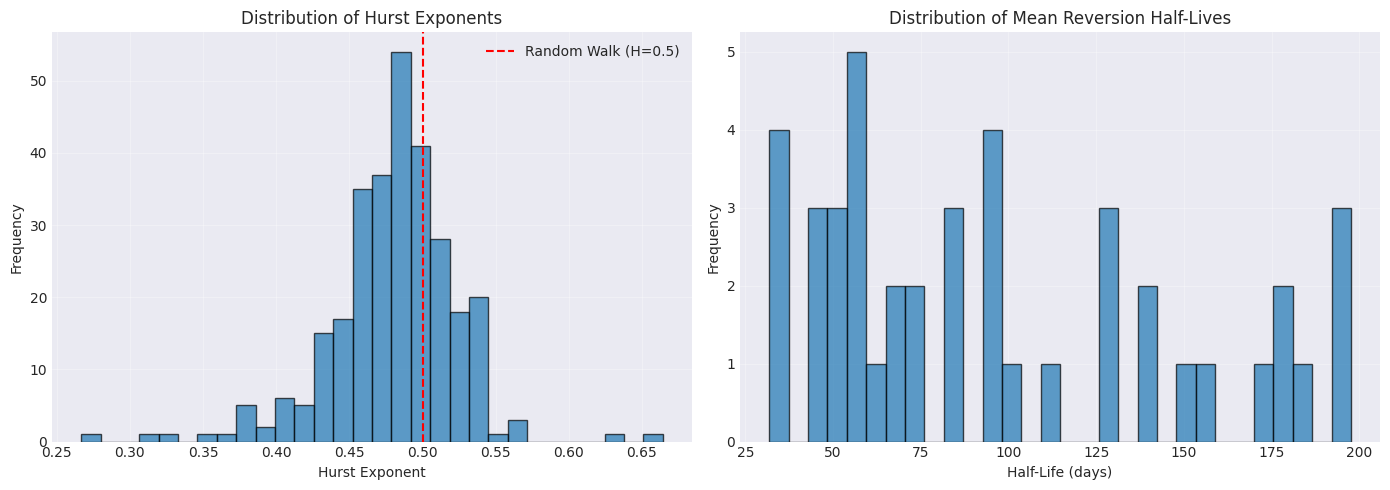

In [7]:
# Visualize Hurst distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hurst histogram
axes[0].hist(analysis_df['hurst'].dropna(), bins=30, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Random Walk (H=0.5)')
axes[0].set_xlabel('Hurst Exponent')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Hurst Exponents')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Half-life histogram
half_lives = analysis_df['half_life'].dropna()
axes[1].hist(half_lives[half_lives < 200], bins=30, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Half-Life (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Mean Reversion Half-Lives')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Filter to mean-reverting stocks only
mean_reverting_symbols = analysis_df[analysis_df['is_mean_reverting']]['symbol'].tolist()
print(f"Trading universe: {len(mean_reverting_symbols)} mean-reverting stocks")
print(f"\nTop 10 most mean-reverting (lowest Hurst):")
print(analysis_df.head(10)[['symbol', 'hurst', 'half_life']])

Trading universe: 216 mean-reverting stocks

Top 10 most mean-reverting (lowest Hurst):
    symbol   hurst  half_life
209   BBWI  0.2667    84.9505
95    KTOS  0.3162        NaN
206   LUMN  0.3261    73.9186
292   FIVE  0.3549   197.5891
106   DUOL  0.3683   141.8791
207   NEOG  0.3732   128.1406
246    MPC  0.3755        NaN
47    AFRM  0.3810    64.8957
15    CORT  0.3812    35.8505
228   CELH  0.3815   102.7269


## 4. Generate Signals

Generate mean reversion signals for the filtered universe.

In [9]:
import time
import importlib
import strategies.mean_reversion as mr_module
importlib.reload(mr_module)
from strategies.mean_reversion import MeanReversionSignals, SignalConfig

# Initialize signal generator with config
signal_config = config.to_signal_config()
signal_gen = MeanReversionSignals(signal_config)

# Get composite weights from config
composite_weights = config.get_composite_weights()

# Generate signals for ALL mean-reverting stocks
show_progress = config.get('logging.show_progress', True)
progress_interval = config.get('logging.progress_interval', 50)

print("Generating signals for all mean-reverting stocks...")
print(f"Using weights: {composite_weights}")
print(f"Kalman Filter: {'ON' if signal_config.use_kalman else 'OFF'}")
print(f"OU Prediction Gate: {'ON' if signal_config.use_predicted_return else 'OFF'}")
print(f"Log Prices: {'ON' if signal_config.use_log_prices else 'OFF'}\n")

all_signals = {}
all_individual_signals = {}

t_start = time.perf_counter()

for i, symbol in enumerate(mean_reverting_symbols):
    if symbol in price_data and symbol in volume_data:
        prices = price_data[symbol]
        volumes = volume_data[symbol]
        
        composite, individual = signal_gen.generate_composite_signal(
            prices, volumes, weights=composite_weights
        )
        all_signals[symbol] = composite
        all_individual_signals[symbol] = individual

    if show_progress and (i + 1) % progress_interval == 0:
        elapsed = time.perf_counter() - t_start
        print(f"  Processed {i + 1}/{len(mean_reverting_symbols)} symbols... ({elapsed:.1f}s)")

t_elapsed = time.perf_counter() - t_start
print(f"\nGenerated signals for {len(all_signals)} symbols in {t_elapsed:.2f}s")
print(f"  Per symbol: {t_elapsed/len(all_signals)*1000:.1f}ms")

# Show signal info
sample_sym = list(all_signals.keys())[0]
sample_sig = all_signals[sample_sym]
sample_ind = all_individual_signals[sample_sym]
entry_threshold = config.get('backtest.entry_threshold', 2.0)
print(f"\nSample signal stats ({sample_sym}):")
print(f"  Range: [{sample_sig.min():.2f}, {sample_sig.max():.2f}]")
print(f"  |signal| > {entry_threshold}: {(sample_sig.abs() > entry_threshold).sum()} days")
print(f"  |signal| > {entry_threshold*0.75}: {(sample_sig.abs() > entry_threshold*0.75).sum()} days")

# Show available signal components
print(f"\n  Signal components: {list(sample_ind.keys())}")
if 'expected_return' in sample_ind:
    exp_ret = sample_ind['expected_return']
    hurdle = config.get('signals.ou_prediction.hurdle_rate', 0.005)
    gated_pct = (exp_ret.abs() < hurdle).sum() / len(exp_ret) * 100
    print(f"  OU hurdle gate filters out {gated_pct:.1f}% of signals")

Generating signals for all mean-reverting stocks...
Using weights: {'bollinger': 0.0, 'rsi_divergence': 0.75, 'rsi_level': 0.0}
Kalman Filter: ON
OU Prediction Gate: ON
Log Prices: ON

  Processed 50/216 symbols... (0.9s)
  Processed 100/216 symbols... (1.8s)
  Processed 150/216 symbols... (2.9s)
  Processed 200/216 symbols... (4.2s)

Generated signals for 216 symbols in 4.52s
  Per symbol: 20.9ms

Sample signal stats (BBWI):
  Range: [-4.53, 2.26]
  |signal| > 1.43: 48 days
  |signal| > 1.0725: 67 days

  Signal components: ['kalman_mean', 'kalman_std', 'zscore', 'expected_return', 'time_to_reversion', 'bollinger', 'rsi_divergence', 'rsi_level']
  OU hurdle gate filters out 2.2% of signals


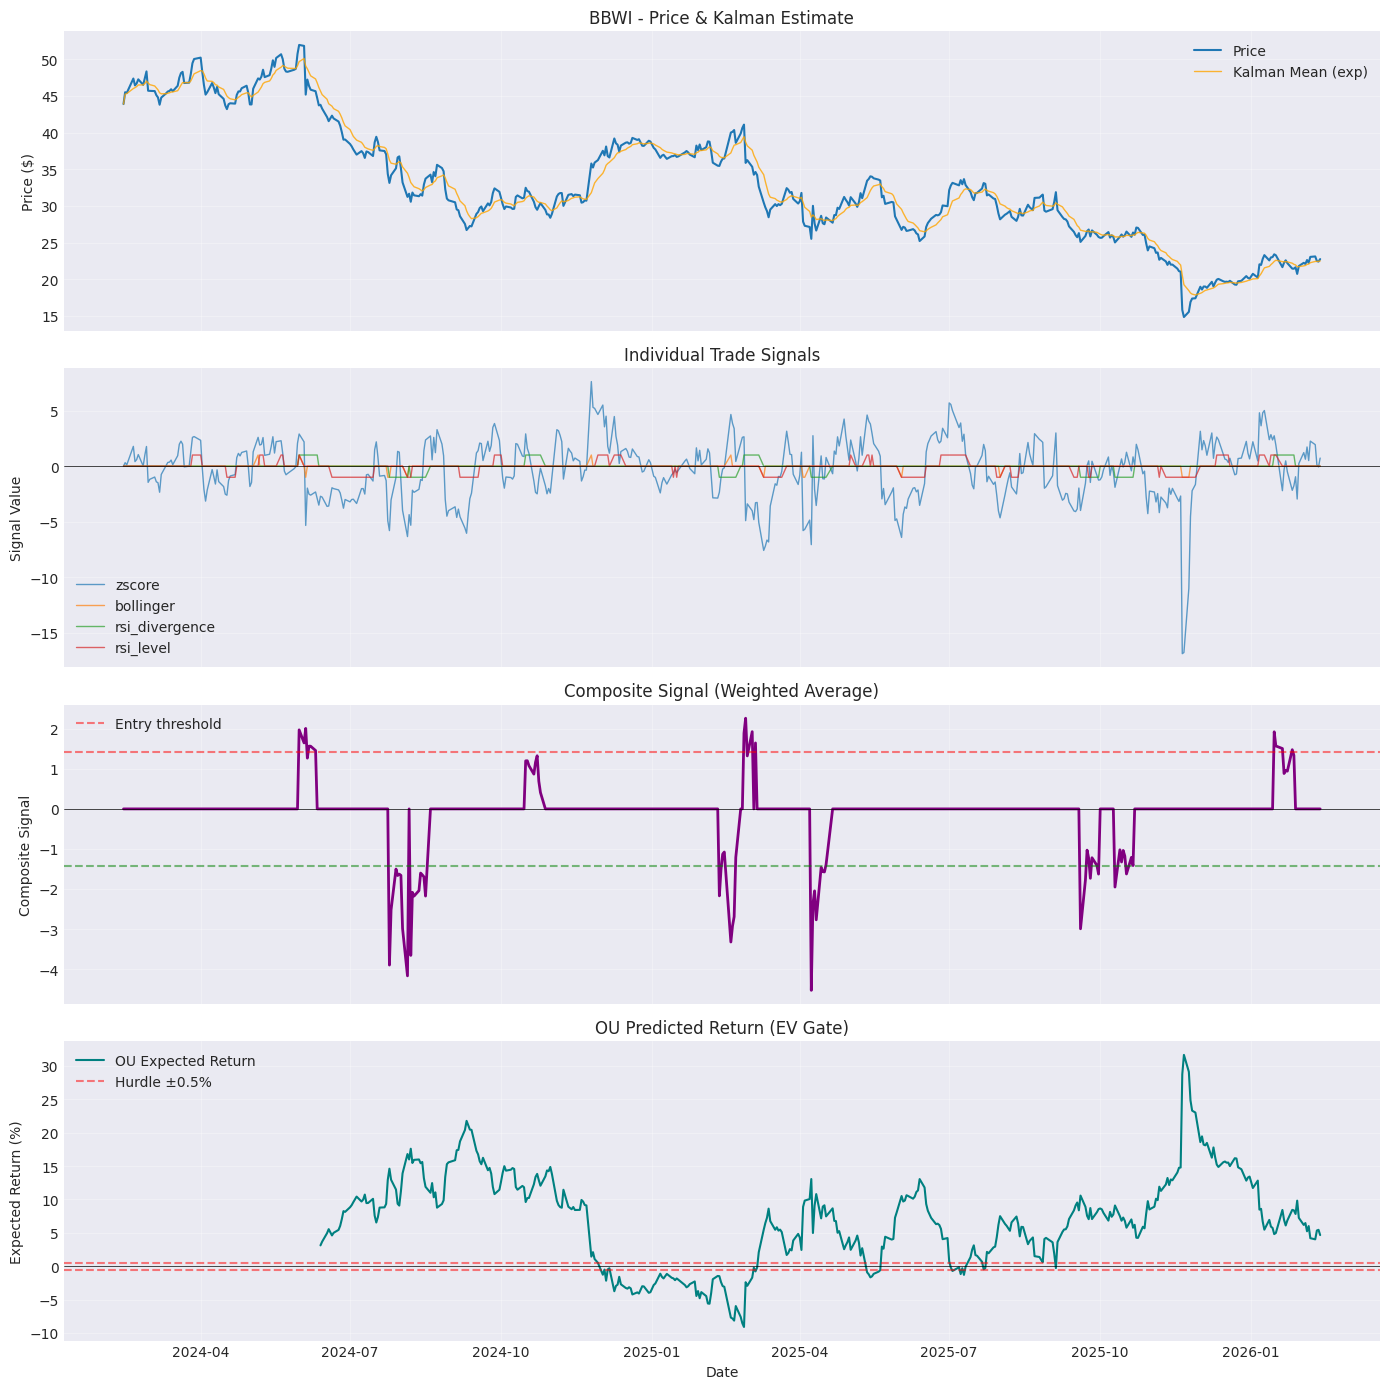

In [10]:
# Visualize signals for a sample stock
sample_symbol = mean_reverting_symbols[0]
sample_price = price_data[sample_symbol]
sample_signal = all_signals[sample_symbol]
sample_individual = all_individual_signals[sample_symbol]

# Separate trade signals from diagnostic signals
trade_signal_keys = ['zscore', 'bollinger', 'rsi_divergence', 'rsi_level']
diagnostic_keys = ['kalman_mean', 'kalman_std', 'expected_return', 'time_to_reversion']

has_diagnostics = any(k in sample_individual for k in diagnostic_keys)
n_rows = 4 if has_diagnostics else 3

fig, axes = plt.subplots(n_rows, 1, figsize=(14, 3.5 * n_rows), sharex=True)

# Price + Kalman mean overlay
axes[0].plot(sample_price.index, sample_price, linewidth=1.5, label='Price')
if 'kalman_mean' in sample_individual:
    kalman_mean = sample_individual['kalman_mean']
    # Kalman mean is in log space if use_log_prices; convert back
    use_log = config.get('signals.use_log_prices', True)
    if use_log:
        axes[0].plot(kalman_mean.index, np.exp(kalman_mean), linewidth=1, color='orange',
                     alpha=0.8, label='Kalman Mean (exp)')
    else:
        axes[0].plot(kalman_mean.index, kalman_mean, linewidth=1, color='orange',
                     alpha=0.8, label='Kalman Mean')
axes[0].set_ylabel('Price ($)')
axes[0].set_title(f'{sample_symbol} - Price & Kalman Estimate')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Individual trade signals
for name in trade_signal_keys:
    if name in sample_individual:
        signal = sample_individual[name]
        axes[1].plot(signal.index, signal, label=name, alpha=0.7, linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Signal Value')
axes[1].set_title('Individual Trade Signals')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Composite signal
axes[2].plot(sample_signal.index, sample_signal, color='purple', linewidth=2)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
entry_th = config.get('backtest.entry_threshold', 2.0)
axes[2].axhline(y=entry_th, color='red', linestyle='--', alpha=0.5, label='Entry threshold')
axes[2].axhline(y=-entry_th, color='green', linestyle='--', alpha=0.5)
axes[2].set_ylabel('Composite Signal')
axes[2].set_title('Composite Signal (Weighted Average)')
axes[2].legend()
axes[2].grid(alpha=0.3)

# OU Expected Return (if available)
if has_diagnostics and n_rows == 4:
    if 'expected_return' in sample_individual:
        exp_ret = sample_individual['expected_return']
        hurdle = config.get('signals.ou_prediction.hurdle_rate', 0.005)
        axes[3].plot(exp_ret.index, exp_ret * 100, color='teal', linewidth=1.5, label='OU Expected Return')
        axes[3].axhline(y=hurdle * 100, color='red', linestyle='--', alpha=0.5, label=f'Hurdle ±{hurdle*100:.1f}%')
        axes[3].axhline(y=-hurdle * 100, color='red', linestyle='--', alpha=0.5)
        axes[3].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[3].set_ylabel('Expected Return (%)')
        axes[3].set_title('OU Predicted Return (EV Gate)')
        axes[3].legend()
        axes[3].grid(alpha=0.3)
    axes[3].set_xlabel('Date')
else:
    axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 5. Backtest with Default Parameters

Run initial backtest to establish baseline performance.

In [11]:
# Convert to DataFrames for backtesting
price_df = pd.DataFrame(price_data)
signal_df = pd.DataFrame(all_signals)
volume_df = pd.DataFrame(volume_data)

# Create z-score DataFrame for exit decisions (used in gated mode)
# In gated mode, entries use composite signal but exits use raw z-score
# so positions exit when price reverts to mean, not when divergence disappears
zscore_df = pd.DataFrame({
    symbol: signals['zscore']
    for symbol, signals in all_individual_signals.items()
    if 'zscore' in signals
})

# Align data (same dates)
common_index = price_df.index.intersection(signal_df.index)
price_df = price_df.loc[common_index]
signal_df = signal_df.loc[common_index]
volume_df = volume_df.loc[common_index]
zscore_df = zscore_df.loc[common_index]

print(f"Backtest data prepared:")
print(f"  Date range: {common_index.min()} to {common_index.max()}")
print(f"  Trading days: {len(common_index)}")
print(f"  Symbols: {len(signal_df.columns)}")
print(f"  Exit signal (z-score) columns: {len(zscore_df.columns)}")

Backtest data prepared:
  Date range: 2006-02-14 00:00:00 to 2026-02-13 00:00:00
  Trading days: 5032
  Symbols: 216
  Exit signal (z-score) columns: 216


In [12]:
# Run backtest with config
print("Running backtest...\n")

bt_config = config.to_backtest_config()

engine = BacktestEngine(bt_config)
results = engine.run_backtest(price_df, signal_df, volume_df, exit_signal_data=zscore_df)

print("Backtest complete!\n")
print("Performance Summary:")
print("="*50)
for key, value in results.summary().items():
    print(f"{key:25s}: {value}")

# Additional sizing info
print(f"\n--- Position Sizing ---")
print(f"Method: {bt_config.position_size_method}")
if bt_config.position_size_method == 'volatility_scaled':
    print(f"Target Vol: {bt_config.vol_target*100:.0f}%  Lookback: {bt_config.vol_lookback}d")
    print(f"Size Range: [{bt_config.vol_min_size*100:.0f}%, {bt_config.vol_max_size*100:.0f}%]")
elif bt_config.position_size_method == 'kelly':
    print(f"Kelly Fraction: {bt_config.kelly_fraction:.1%}  Lookback: {bt_config.kelly_lookback}d")

# Phase B.1-B.3 info
print(f"\n--- Phase B Features ---")
print(f"Signal Mode: {config.get('signals.signal_mode', 'gated')}")
print(f"Gate Signal: {config.get('signals.gate_signal', 'rsi_divergence')}")
print(f"Dynamic Short Filter: {config.get('signals.dynamic_short_filter.enabled', True)}")
print(f"Trailing Stop: {bt_config.use_trailing_stop} (trail={bt_config.trailing_stop_pct:.0%}, activate={bt_config.trailing_stop_activation:.0%})")
print(f"Time Decay Exit: {bt_config.use_time_decay_exit} (after {bt_config.time_decay_days}d, threshold={bt_config.time_decay_threshold:.0%})")

# Short protection info
print(f"\n--- Short Protection (Option C) ---")
print(f"Stop Loss (longs): {bt_config.stop_loss_pct*100:.0f}%" if bt_config.stop_loss_pct else "Stop Loss (longs): Disabled")
sl_short = bt_config.short_stop_loss_pct if bt_config.short_stop_loss_pct is not None else bt_config.stop_loss_pct
print(f"Stop Loss (shorts): {sl_short*100:.0f}%" if sl_short else "Stop Loss (shorts): Disabled")
print(f"Acceleration Filter: {bt_config.short_accel_filter} (lookback={bt_config.short_accel_lookback}d, threshold={bt_config.short_accel_threshold*100:.0f}%)")

Running backtest...

Backtest complete!

Performance Summary:
Total Return             : 60401122255.68%
Final Equity             : $60,401,122,355,683.18
Annualized Return        : 175.26%
Sharpe Ratio             : 5.32
Sortino Ratio            : 8.11
Calmar Ratio             : 10.91
Max Drawdown             : 16.06%
Max DD Duration          : 33 days
Total Trades             : 20769
Win Rate                 : 62.93%
Profit Factor            : 2.20
EV Per Trade             : 1.000%
EV Long                  : 0.847%
EV Short                 : 1.413%
Avg Win                  : 2.88%
Avg Loss                 : -2.20%
Avg Holding              : 2.6 days
Avg Exposure             : 72.79%
Max Positions            : 11
Total Commission         : $18,062,721,228,047.04

--- Position Sizing ---
Method: volatility_scaled
Target Vol: 15%  Lookback: 60d
Size Range: [2%, 10%]

--- Phase B Features ---
Signal Mode: gated
Gate Signal: rsi_divergence
Dynamic Short Filter: True
Trailing Stop: True (t

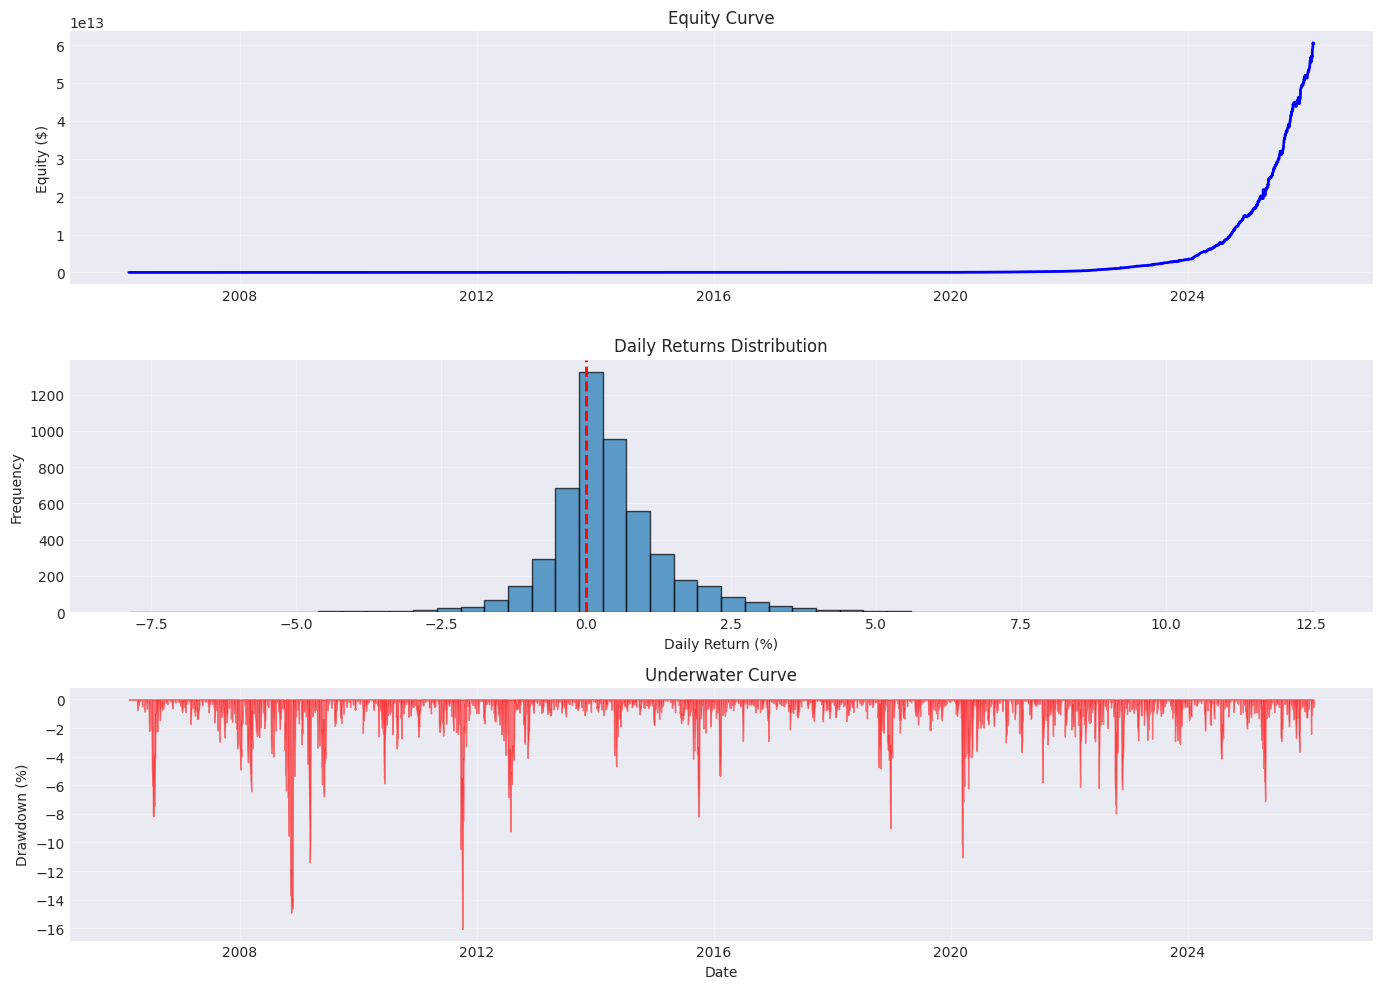

In [13]:
# Visualize backtest results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Equity curve
axes[0].plot(results.equity_curve, linewidth=2, color='blue')
axes[0].set_ylabel('Equity ($)')
axes[0].set_title('Equity Curve')
axes[0].grid(alpha=0.3)

# Returns distribution
axes[1].hist(results.returns * 100, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Daily Return (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Daily Returns Distribution')
axes[1].grid(alpha=0.3)

# Drawdown
drawdown = calculate_underwater_curve(results.equity_curve)
axes[2].fill_between(drawdown.index, 0, drawdown * 100, alpha=0.5, color='red')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Drawdown (%)')
axes[2].set_title('Underwater Curve')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Analyze trades
if results.trades:
    trades_df = pd.DataFrame([
        {
            'symbol': t.symbol,
            'entry_date': t.entry_date,
            'exit_date': t.exit_date,
            'side': t.side,
            'pnl_pct': t.pnl_pct * 100,
            'holding_days': t.holding_days,
            'exit_reason': t.exit_reason
        }
        for t in results.trades
    ])
    
    print("\nTrade Analysis:")
    print(f"Total trades: {len(trades_df)}")
    print(f"\nBy side:")
    print(trades_df['side'].value_counts())
    print(f"\nBy exit reason:")
    print(trades_df['exit_reason'].value_counts())
    print(f"\nTop 10 trades:")
    print(trades_df.nlargest(10, 'pnl_pct')[['symbol', 'side', 'pnl_pct', 'holding_days', 'exit_reason']])


Trade Analysis:
Total trades: 20769

By side:
side
long     15136
short     5633
Name: count, dtype: int64

By exit reason:
exit_reason
signal           20050
stop_loss          348
take_profit        138
time_decay         107
trailing_stop      103
max_holding         23
Name: count, dtype: int64

Top 10 trades:
      symbol  side  pnl_pct  holding_days  exit_reason
2910    PATK  long  47.8419             5  take_profit
18170   POWL  long  44.9072             1  take_profit
3182    PATK  long  43.1137             1  take_profit
2971    EXAS  long  42.4929             1  take_profit
20525    ANF  long  37.1837             1  take_profit
18943   PCVX  long  36.0372             4  take_profit
2697     UNH  long  34.4029             3  take_profit
956     ALGN  long  33.0586             1  take_profit
4794    PATK  long  32.6504             3  take_profit
2842    PATK  long  32.4631             3  take_profit


In [15]:
# ============================================================================
# COMPREHENSIVE 20-YEAR ANALYSIS — Phase 3B Prioritization
# ============================================================================

trades_df = pd.DataFrame([
    {
        'symbol': t.symbol, 'entry_date': t.entry_date, 'exit_date': t.exit_date,
        'side': t.side, 'pnl': t.pnl, 'pnl_pct': t.pnl_pct * 100,
        'holding_days': t.holding_days, 'exit_reason': t.exit_reason,
        'entry_price': t.entry_price, 'exit_price': t.exit_price,
        'entry_signal': t.entry_signal
    }
    for t in results.trades
])
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
trades_df['year'] = trades_df['entry_date'].dt.year

# ─── 1. YEARLY PERFORMANCE BREAKDOWN ───
print("=" * 80)
print("1. YEARLY PERFORMANCE BREAKDOWN")
print("=" * 80)
yearly = trades_df.groupby('year').agg(
    trades=('pnl', 'count'),
    total_pnl=('pnl', 'sum'),
    avg_pnl_pct=('pnl_pct', 'mean'),
    win_rate=('pnl_pct', lambda x: (x > 0).mean() * 100),
    best_trade=('pnl_pct', 'max'),
    worst_trade=('pnl_pct', 'min'),
    avg_holding=('holding_days', 'mean')
).round(2)
print(yearly.to_string())

# ─── 2. ROLLING METRICS ───
print("\n" + "=" * 80)
print("2. ANNUAL EQUITY RETURNS")
print("=" * 80)
equity = results.equity_curve
returns = results.returns
annual_equity = equity.resample('YE').last()
annual_returns = annual_equity.pct_change().dropna()
print("\nAnnual equity returns:")
for dt, ret in annual_returns.items():
    print(f"  {dt.year}: {ret*100:+.2f}%")

# ─── 3. DRAWDOWN ANALYSIS ───
print("\n" + "=" * 80)
print("3. DRAWDOWN ANALYSIS")
print("=" * 80)
dd = calculate_underwater_curve(equity)
rolling_max = equity.cummax()
drawdown_series = (equity - rolling_max) / rolling_max
dd_starts = []
i = 0
dates = drawdown_series.index.tolist()
vals = drawdown_series.values
while i < len(vals):
    if vals[i] < -0.001:
        start = i
        min_dd = vals[i]
        min_idx = i
        while i < len(vals) and vals[i] < -0.001:
            if vals[i] < min_dd:
                min_dd = vals[i]
                min_idx = i
            i += 1
        dd_starts.append({'start': dates[start], 'trough': dates[min_idx], 
                          'end': dates[min(i, len(dates)-1)], 
                          'depth': min_dd * 100, 'duration': i - start})
    i += 1

top_dds = sorted(dd_starts, key=lambda x: x['depth'])[:5]
print(f"\nTop 5 drawdowns:")
for j, d in enumerate(top_dds, 1):
    print(f"  #{j}: {d['depth']:.2f}%  | {d['start'].strftime('%Y-%m-%d')} → {d['end'].strftime('%Y-%m-%d')} ({d['duration']} days)")

# ─── 4. LONG vs SHORT ───
print("\n" + "=" * 80)
print("4. LONG vs SHORT PERFORMANCE")
print("=" * 80)
for side in ['long', 'short']:
    side_df = trades_df[trades_df['side'] == side]
    print(f"\n  {side.upper()} ({len(side_df)} trades):")
    print(f"    Win Rate: {(side_df['pnl_pct'] > 0).mean()*100:.1f}%")
    print(f"    Avg PnL: {side_df['pnl_pct'].mean():.2f}%")
    print(f"    Total PnL: ${side_df['pnl'].sum():,.0f}")
    print(f"    Avg Holding: {side_df['holding_days'].mean():.1f} days")
    print(f"    Worst Trade: {side_df['pnl_pct'].min():.2f}%")

# ─── 5. EXIT REASON ANALYSIS ───
print("\n" + "=" * 80)
print("5. EXIT REASON ANALYSIS")
print("=" * 80)
for reason in trades_df['exit_reason'].unique():
    r_df = trades_df[trades_df['exit_reason'] == reason]
    print(f"\n  {reason.upper()} ({len(r_df)} trades, {len(r_df)/len(trades_df)*100:.1f}%):")
    print(f"    Avg PnL: {r_df['pnl_pct'].mean():.2f}%")
    print(f"    Win Rate: {(r_df['pnl_pct'] > 0).mean()*100:.1f}%")
    print(f"    Total PnL: ${r_df['pnl'].sum():,.0f}")

# ─── 6. CAPITAL UTILIZATION ───
print("\n" + "=" * 80)
print("6. CAPITAL UTILIZATION & EFFICIENCY")
print("=" * 80)
total_days = len(equity)
days_with_trades = trades_df['entry_date'].nunique()
print(f"  Total trading days: {total_days}")
print(f"  Days with entries: {days_with_trades} ({days_with_trades/total_days*100:.1f}%)")
print(f"  Avg exposure: {results.avg_exposure*100:.2f}%")
print(f"  Max positions: {results.max_positions}")
print(f"  Final equity: ${equity.iloc[-1]:,.0f}")
print(f"  Total commission: ${results.total_commission:,.0f}")
print(f"  Return per unit exposure: {results.total_return / max(results.avg_exposure, 0.001):.1f}x")

# ─── 7. SIGNAL STRENGTH vs OUTCOME ───
print("\n" + "=" * 80)
print("7. SIGNAL STRENGTH vs OUTCOME")
print("=" * 80)
trades_df['abs_signal'] = trades_df['entry_signal'].abs()
signal_bins = pd.qcut(trades_df['abs_signal'], q=4, labels=['Weak', 'Moderate', 'Strong', 'Very Strong'])
signal_analysis = trades_df.groupby(signal_bins, observed=True).agg(
    trades=('pnl_pct', 'count'),
    avg_pnl=('pnl_pct', 'mean'),
    win_rate=('pnl_pct', lambda x: (x > 0).mean() * 100)
).round(2)
print(signal_analysis.to_string())

# ─── 8. REGIME ANALYSIS ───
print("\n" + "=" * 80)
print("8. REGIME ANALYSIS (Crisis Periods)")
print("=" * 80)
crisis_periods = [
    ('GFC', '2007-10-01', '2009-03-31'),
    ('Flash Crash', '2010-04-01', '2010-06-30'),
    ('EU Crisis', '2011-07-01', '2011-12-31'),
    ('Oil Crash', '2015-06-01', '2016-02-28'),
    ('Vol-mageddon', '2018-01-01', '2018-12-31'),
    ('COVID Crash', '2020-02-01', '2020-04-30'),
    ('Post-COVID Recovery', '2020-05-01', '2021-12-31'),
    ('2022 Bear', '2022-01-01', '2022-12-31'),
    ('2023 Recovery', '2023-01-01', '2023-12-31'),
    ('2024 Bull', '2024-01-01', '2024-12-31'),
]
for name, start, end in crisis_periods:
    period_trades = trades_df[(trades_df['entry_date'] >= start) & (trades_df['entry_date'] <= end)]
    period_equity = equity[(equity.index >= start) & (equity.index <= end)]
    if len(period_trades) > 0:
        period_ret = (period_equity.iloc[-1] / period_equity.iloc[0] - 1) * 100 if len(period_equity) > 1 else 0
        print(f"  {name:25s} | {len(period_trades):3d} trades | WR: {(period_trades['pnl_pct'] > 0).mean()*100:5.1f}% | Avg PnL: {period_trades['pnl_pct'].mean():+6.2f}% | Period Ret: {period_ret:+7.2f}%")
    else:
        print(f"  {name:25s} | No trades")

# ─── 9. THE -200% SHORT TRADE (OUTLIER) ───
print("\n" + "=" * 80)
print("9. OUTLIER TRADE INVESTIGATION")
print("=" * 80)
outliers = trades_df[trades_df['pnl_pct'] < -10]
if len(outliers) > 0:
    for _, t in outliers.iterrows():
        print(f"  CATASTROPHIC: {t['symbol']} {t['side']} | Entry: {t['entry_date'].strftime('%Y-%m-%d')} @ ${t['entry_price']:.2f}")
        print(f"    Exit: {t['exit_date'].strftime('%Y-%m-%d')} @ ${t['exit_price']:.2f} | PnL: {t['pnl_pct']:.2f}% (${t['pnl']:,.0f})")
        print(f"    Exit Reason: {t['exit_reason']} | Holding: {t['holding_days']} days | Signal: {t['entry_signal']:.4f}")
else:
    print("  No catastrophic outlier trades (all > -10%)")

# ─── 10. SUMMARY COMPARISON ───
print("\n" + "=" * 80)
print("SUMMARY: Config Evolution (20-Year Backtest)")
print("=" * 80)
print(f"{'Metric':25s} {'Pre-Option C':>20s} {'Option C (v1)':>20s} {'Consensus (v2)':>20s}")
print("-" * 85)
print(f"{'Total Return':25s} {'3,195.51%':>20s} {'2,969.53%':>20s} {f'{results.total_return*100:.2f}%':>20s}")
print(f"{'Sharpe Ratio':25s} {'2.47':>20s} {'3.55':>20s} {f'{results.sharpe_ratio:.2f}':>20s}")
print(f"{'Max Drawdown':25s} {'20.02%':>20s} {'1.25%':>20s} {f'{results.max_drawdown*100:.2f}%':>20s}")
print(f"{'Win Rate':25s} {'98.40%':>20s} {'98.95%':>20s} {f'{results.win_rate*100:.2f}%':>20s}")
print(f"{'Total Trades':25s} {'812':>20s} {'763':>20s} {f'{results.total_trades}':>20s}")
print(f"{'Avg Exposure':25s} {'3.49%':>20s} {'3.89%':>20s} {f'{results.avg_exposure*100:.2f}%':>20s}")
print(f"{'Profit Factor':25s} {'49.24':>20s} {'1,197.73':>20s} {f'{results.profit_factor:.2f}':>20s}")
print(f"{'Final Equity':25s} {'$32.0M':>20s} {'$30.7M':>20s} {f'${results.equity_curve.iloc[-1]/1e6:.1f}M':>20s}")

1. YEARLY PERFORMANCE BREAKDOWN
      trades   total_pnl  avg_pnl_pct  win_rate  best_trade  worst_trade  avg_holding
year                                                                                 
2006     748  1.0398e+05         0.97     63.50       22.76       -17.13         2.56
2007     983  2.7068e+05         0.88     58.80       33.06       -12.94         2.39
2008    1302  2.1696e+06         1.41     60.52       47.84       -29.37         2.45
2009    1144  9.3726e+06         1.39     65.91       43.11       -30.21         2.52
2010     979  2.0246e+07         1.03     63.13       32.65       -15.42         2.55
2011    1092  6.5118e+07         1.04     62.45       20.84       -18.14         2.42
2012     859  7.2242e+07         0.66     60.30       18.80       -31.78         2.71
2013     810  1.6734e+08         0.86     65.43       21.90       -17.36         2.60
2014     772  2.3432e+08         0.69     60.36       19.75       -13.93         2.67
2015    1023  5.6690e+

## 6. Parameter Optimization

Use walk-forward analysis to find optimal parameters.

In [16]:
# Configure optimization from config (toggle-aware)
optimization_enabled = config.get('optimization.enabled', True)

if not optimization_enabled:
    print("⏭️  Optimization DISABLED in config.yaml (optimization.enabled: false)")
    print("   Using current config parameters for backtest.")
    opt_results = None
else:
    opt_config = config.to_optimization_config()

    # Pass base backtest config so optimizer inherits sizing/log-return settings
    optimizer = ParameterOptimizer(opt_config, base_backtest_config=bt_config)

    print("Optimization configuration:")
    print(f"  Method: {opt_config.method}")
    print(f"  Trials: {opt_config.n_trials}  |  Parallel jobs: {opt_config.n_jobs}")
    print(f"  Train period: {opt_config.train_period_days} days")
    print(f"  Test period: {opt_config.test_period_days} days")
    print(f"  Step size: {opt_config.step_days} days")
    print(f"  Objective: {opt_config.objective_metric}")
    if opt_config.method == 'bayesian':
        print(f"  Bayesian ranges:")
        print(f"    entry_threshold: {list(opt_config.bayesian_entry_range)}")
        print(f"    exit_threshold: {list(opt_config.bayesian_exit_range)}")
        print(f"    stop_loss: {opt_config.bayesian_stop_loss_choices}")
        print(f"    take_profit: {opt_config.bayesian_take_profit_choices}")
        print(f"    max_holding: {opt_config.bayesian_max_holding_choices}")
    else:
        print(f"  Grid ranges:")
        print(f"    entry_threshold: {opt_config.entry_threshold_range}")
        print(f"    exit_threshold: {opt_config.exit_threshold_range}")
        print(f"    stop_loss: {opt_config.stop_loss_range}")
        print(f"    take_profit: {opt_config.take_profit_range}")
    print(f"\n  Base sizing config inherited:")
    print(f"    position_size_method: {bt_config.position_size_method}")
    print(f"    use_log_returns: {bt_config.use_log_returns}")

⏭️  Optimization DISABLED in config.yaml (optimization.enabled: false)
   Using current config parameters for backtest.


In [17]:
if optimization_enabled:
    # Create signal generator function for optimizer
    def signal_generator_fn(params):
        """Generate signals (independent of backtest params)"""
        return signal_df

    # Run optimization
    print("Running walk-forward optimization...")
    print("This may take several minutes...\n")

    opt_results = optimizer.walk_forward_optimization(
        price_df,
        signal_generator_fn,
        volume_df,
        exit_signal_data=zscore_df
    )

    print("\n" + "="*50)
    print("Optimization complete!")
    print("="*50)
    print("\nSummary:")
    for key, value in opt_results.summary().items():
        print(f"{key:25s}: {value}")
else:
    print("⏭️  Optimization skipped.")

⏭️  Optimization skipped.


In [18]:
# Plot optimization results (if optimization was enabled)
if opt_results is not None:
    plot_wf_results(opt_results)
else:
    print("No optimization results to plot.")

No optimization results to plot.


In [19]:
# Parameter stability analysis (if optimization was enabled)
if opt_results is not None:
    print("\nParameter Frequency (across all periods):")
    print("="*50)
    for param, count in sorted(opt_results.best_params_frequency.items(), key=lambda x: x[1], reverse=True):
        print(f"{param:30s}: {count} times")
else:
    print("No optimization results for parameter stability analysis.")

No optimization results for parameter stability analysis.


In [20]:
# Compare individual signals vs composite
# Note: zscore is on z-score scale (can cross 2.0), but bollinger/rsi are [-1, 0, +1]
# so we test those with a lower threshold (0.5) to see their standalone performance
# Diagnostic signals (kalman_mean, kalman_std, expected_return, time_to_reversion) are skipped
# Phase B.4: All signals now inherit full risk management params (stop loss, trailing stop, etc.)

print("Testing individual signals...\n")

individual_results = {}
# Only backtest actual trade signals, skip diagnostic outputs
signal_types = ['zscore', 'bollinger', 'rsi_divergence', 'rsi_level']
diagnostic_keys = {'kalman_mean', 'kalman_std', 'expected_return', 'time_to_reversion'}

from dataclasses import asdict

for signal_type in signal_types:
    # Check that this signal exists in individual signals
    first_sym = next(iter(all_individual_signals))
    if signal_type not in all_individual_signals[first_sym]:
        continue
    
    # Extract individual signal for all symbols
    individual_signal_df = pd.DataFrame({
        symbol: signals[signal_type]
        for symbol, signals in all_individual_signals.items()
        if signal_type in signals
    })
    
    # Align with prices
    individual_signal_df = individual_signal_df.loc[common_index]
    
    # Use appropriate threshold: z-score scale for zscore, lower for binary signals
    if signal_type == 'zscore':
        threshold = bt_config.entry_threshold
        exit_th = bt_config.exit_threshold
    else:
        threshold = 0.5  # These are [-1, 0, +1] signals
        exit_th = 0.1
    
    # Inherit ALL risk management params from base config (Phase B.4)
    # Only override entry/exit thresholds per signal type
    base_dict = asdict(bt_config)
    base_dict['entry_threshold'] = threshold
    base_dict['exit_threshold'] = exit_th
    ind_bt_config = BacktestConfig(**base_dict)
    
    ind_engine = BacktestEngine(ind_bt_config)
    result = ind_engine.run_backtest(price_df, individual_signal_df, volume_df)
    individual_results[signal_type] = result
    
    ev_str = f" | EV/trade: {result.ev_per_trade*100:.3f}%" if hasattr(result, 'ev_per_trade') and result.ev_per_trade is not None else ""
    print(f"{signal_type:20s} - Return: {result.total_return*100:6.2f}% | Sharpe: {result.sharpe_ratio:5.2f} | Trades: {result.total_trades}{ev_str}")

# Composite uses the standard threshold
ev_str = f" | EV/trade: {results.ev_per_trade*100:.3f}%" if hasattr(results, 'ev_per_trade') and results.ev_per_trade is not None else ""
print(f"\n{'Composite (gated)':20s} - Return: {results.total_return*100:6.2f}% | Sharpe: {results.sharpe_ratio:5.2f} | Trades: {results.total_trades}{ev_str}")

Testing individual signals...



zscore               - Return: -82.07% | Sharpe: -0.42 | Trades: 11322 | EV/trade: -0.105%
bollinger            - Return: -99.57% | Sharpe: -1.73 | Trades: 15645 | EV/trade: -0.327%
rsi_divergence       - Return: 13199459018.06% | Sharpe:  5.16 | Trades: 9211 | EV/trade: 2.072%
rsi_level            - Return: -97.19% | Sharpe: -0.81 | Trades: 14031 | EV/trade: -0.224%

Composite (gated)    - Return: 60401122255.68% | Sharpe:  5.32 | Trades: 20769 | EV/trade: 1.000%


In [21]:
# Visualize strategy comparison
fig = go.Figure()

# Add traces for each strategy
for name, result in individual_results.items():
    fig.add_trace(go.Scatter(
        x=result.equity_curve.index,
        y=result.equity_curve,
        mode='lines',
        name=name,
        opacity=0.6
    ))

# Add composite
fig.add_trace(go.Scatter(
    x=results.equity_curve.index,
    y=results.equity_curve,
    mode='lines',
    name='Composite',
    line=dict(width=3, color='purple')
))

fig.update_layout(
    title='Strategy Comparison - Equity Curves',
    xaxis_title='Date',
    yaxis_title='Equity ($)',
    hovermode='x unified',
    height=600
)

fig.show()

## 8. Summary & Next Steps

Key insights and recommendations for Phase 3 (ML Filter).

In [22]:
print("Phase 2 / 2.5 Summary:")
print("="*60)
print(f"\n1. Universe Analysis:")
print(f"   - Total stocks analyzed: {len(analysis_df)}")
print(f"   - Mean-reverting stocks: {len(mean_reverting_symbols)}")
print(f"   - Average Hurst exponent: {analysis_df['hurst'].mean():.3f}")

print(f"\n2. Strategy Performance:")
print(f"   - Total Return: {results.total_return*100:.2f}%")
print(f"   - Sharpe Ratio: {results.sharpe_ratio:.2f}")
print(f"   - Max Drawdown: {results.max_drawdown*100:.2f}%")
print(f"   - Win Rate: {results.win_rate*100:.2f}%")
print(f"   - Total Trades: {results.total_trades}")
print(f"   - Profit Factor: {results.profit_factor:.2f}")

# Phase 2.5 EV metrics
if hasattr(results, 'ev_per_trade') and results.ev_per_trade is not None:
    print(f"\n3. Expected Value (EV) Analysis:")
    print(f"   - EV/Trade (overall): {results.ev_per_trade*100:.4f}%")
    if hasattr(results, 'ev_per_trade_long') and results.ev_per_trade_long is not None:
        print(f"   - EV/Trade (long):    {results.ev_per_trade_long*100:.4f}%")
    if hasattr(results, 'ev_per_trade_short') and results.ev_per_trade_short is not None:
        print(f"   - EV/Trade (short):   {results.ev_per_trade_short*100:.4f}%")
    print(f"   - Sizing Method: {bt_config.position_size_method}")
    print(f"   - Log Returns: {bt_config.use_log_returns}")

try:
    if opt_results is not None:
        print(f"\n4. Optimized Strategy Performance:")
        print(f"   - Test Return: {opt_results.combined_test_results.total_return*100:.2f}%")
        print(f"   - Test Sharpe: {opt_results.combined_test_results.sharpe_ratio:.2f}")
        print(f"   - Stability Score: {opt_results.stability_score:.3f}")
    else:
        print(f"\n4. Optimization: (disabled in config)")
except (NameError, AttributeError):
    print(f"\n4. Optimization: (run optimization cells first)")

print(f"\n5. Best Signal Type:")
try:
    best_signal = max(individual_results.items(), key=lambda x: x[1].sharpe_ratio)
    print(f"   - {best_signal[0]}: Sharpe {best_signal[1].sharpe_ratio:.2f}")
except NameError:
    print(f"   - (run strategy comparison cells first)")

# Phase 2.5 config recap
print(f"\n6. Phase 2.5 Upgrades Active:")
print(f"   - Kalman Filter: {config.get('signals.kalman.use_kalman', True)}")
print(f"   - OU Prediction Gate: {config.get('signals.ou_prediction.use_predicted_return', True)}")
print(f"   - Log Prices (z-score): {config.get('signals.use_log_prices', True)}")
print(f"   - Log Returns (metrics): {config.get('backtest.use_log_returns', True)}")
print(f"   - Position Sizing: {config.get('backtest.position_size_method')}")

print("\n" + "="*60)

Phase 2 / 2.5 Summary:

1. Universe Analysis:
   - Total stocks analyzed: 294
   - Mean-reverting stocks: 216
   - Average Hurst exponent: 0.480

2. Strategy Performance:
   - Total Return: 60401122255.68%
   - Sharpe Ratio: 5.32
   - Max Drawdown: 16.06%
   - Win Rate: 62.93%
   - Total Trades: 20769
   - Profit Factor: 2.20

3. Expected Value (EV) Analysis:
   - EV/Trade (overall): 1.0004%
   - EV/Trade (long):    0.8467%
   - EV/Trade (short):   1.4134%
   - Sizing Method: volatility_scaled
   - Log Returns: True

4. Optimization: (disabled in config)

5. Best Signal Type:
   - rsi_divergence: Sharpe 5.16

6. Phase 2.5 Upgrades Active:
   - Kalman Filter: True
   - OU Prediction Gate: True
   - Log Prices (z-score): True
   - Log Returns (metrics): True
   - Position Sizing: volatility_scaled



In [23]:
# Extract consensus parameters from optimizer results
import numpy as np
from collections import Counter

periods = opt_results.walk_forward_results

# Collect all parameters
entries = [p.best_params['entry_threshold'] for p in periods]
exits = [p.best_params['exit_threshold'] for p in periods]
stops = [p.best_params.get('stop_loss_pct') for p in periods]
takes = [p.best_params.get('take_profit_pct') for p in periods]
holdings = [p.best_params.get('max_holding_days') for p in periods]

print("=" * 70)
print("OPTIMIZER PARAMETER CONSENSUS ANALYSIS (34 Walk-Forward Periods)")
print("=" * 70)

print(f"\n--- Entry Threshold ---")
print(f"  Mean: {np.mean(entries):.3f}  |  Median: {np.median(entries):.3f}  |  Std: {np.std(entries):.3f}")
print(f"  Range: [{min(entries):.3f}, {max(entries):.3f}]")
print(f"  25th-75th pctl: [{np.percentile(entries, 25):.3f}, {np.percentile(entries, 75):.3f}]")
print(f"  Current config: 1.500")

print(f"\n--- Exit Threshold ---")
print(f"  Mean: {np.mean(exits):.3f}  |  Median: {np.median(exits):.3f}  |  Std: {np.std(exits):.3f}")
print(f"  Range: [{min(exits):.3f}, {max(exits):.3f}]")
print(f"  25th-75th pctl: [{np.percentile(exits, 25):.3f}, {np.percentile(exits, 75):.3f}]")
print(f"  Current config: 0.817")

print(f"\n--- Stop Loss ---")
stop_counts = Counter(str(s) for s in stops)
print(f"  Distribution: {dict(stop_counts)}")
numeric_stops = [s for s in stops if s is not None]
if numeric_stops:
    print(f"  Numeric mean: {np.mean(numeric_stops):.3f}  |  Median: {np.median(numeric_stops):.3f}")
print(f"  Current config: 0.08")

print(f"\n--- Take Profit ---")
tp_counts = Counter(str(t) for t in takes)
print(f"  Distribution: {dict(tp_counts)}")
numeric_tp = [t for t in takes if t is not None]
if numeric_tp:
    print(f"  Numeric mean: {np.mean(numeric_tp):.3f}  |  Median: {np.median(numeric_tp):.3f}")
print(f"  Current config: 0.15")

print(f"\n--- Max Holding Days ---")
hold_counts = Counter(str(h) for h in holdings)
print(f"  Distribution: {dict(hold_counts)}")
numeric_holds = [h for h in holdings if h is not None]
if numeric_holds:
    print(f"  Numeric mean: {np.mean(numeric_holds):.1f}  |  Median: {np.median(numeric_holds):.0f}")
print(f"  Current config: 30")

# Recommended consensus
print(f"\n{'=' * 70}")
print(f"RECOMMENDED CONSENSUS PARAMETERS")
print(f"{'=' * 70}")
entry_consensus = round(np.median(entries), 2)
exit_consensus = round(np.median(exits), 2)
stop_mode = Counter(stops).most_common(1)[0][0]
tp_mode = Counter(takes).most_common(1)[0][0]
hold_mode = Counter(holdings).most_common(1)[0][0]

print(f"  entry_threshold:  {entry_consensus}  (median, current: 1.50)")
print(f"  exit_threshold:   {exit_consensus}  (median, current: 0.82)")
print(f"  stop_loss_pct:    {stop_mode}  (mode, current: 0.08)")
print(f"  take_profit_pct:  {tp_mode}  (mode, current: 0.15)")
print(f"  max_holding_days: {hold_mode}  (mode, current: 30)")

# OOS performance per period
test_sharpes = [p.test_results.sharpe_ratio for p in periods]
test_returns = [p.test_results.total_return * 100 for p in periods]
pos_periods = sum(1 for s in test_sharpes if s > 0)
print(f"\n{'=' * 70}")
print(f"PERIOD-LEVEL OUT-OF-SAMPLE PERFORMANCE")
print(f"{'=' * 70}")
print(f"  Periods with positive Sharpe: {pos_periods}/{len(test_sharpes)} ({pos_periods/len(test_sharpes)*100:.0f}%)")
print(f"  Mean test Sharpe: {np.mean(test_sharpes):.3f}  |  Median: {np.median(test_sharpes):.3f}")
print(f"  Mean test return: {np.mean(test_returns):.2f}%  |  Median: {np.median(test_returns):.2f}%")
print(f"  Best period Sharpe: {max(test_sharpes):.3f}  |  Worst: {min(test_sharpes):.3f}")

AttributeError: 'NoneType' object has no attribute 'walk_forward_results'

## Phase 9: Performance & Risk Analytics Dashboard

Institutional-grade analytics across 20 years of data.

In [ ]:
# ============================================================================
# 3B — PERFORMANCE ANALYTICS (Capital, Risk, Rolling, Trade, Cost, Regime)
# ============================================================================

from pathlib import Path
from backtest.analytics import PerformanceAnalytics

analytics = PerformanceAnalytics(
    results=results,
    config=bt_config,
    signal_df=signal_df,
    output_dir=project_root / 'DataAnalysisExpert',
)

# 3B.0 — Capital Utilization Diagnostic
cap_report = analytics.capital_utilization()

CAPITAL UTILIZATION DIAGNOSTIC

--- Market Presence ---
  Total trading days:            5,032
  Days with open positions:      1,596 (31.7%)
  Days fully idle (0 positions): 3,436 (68.3%)
  Avg exposure:                  3.89%
  Max concurrent positions:      11

--- Position Sizing When Active ---
  Avg position value:    $104,882
  Avg equity at entry:   $1,049,007
  Avg position % equity: 10.00%
  Max position size cap: 10%
  Avg holding period:    3.6 days

--- Concurrent Positions Distribution ---
   0 positions:  3436 days ( 68.3%) ██████████████████████████████████
   1 positions:   957 days ( 19.0%) █████████
   2 positions:   379 days (  7.5%) ███
   3 positions:   129 days (  2.6%) █
   4 positions:    65 days (  1.3%) 
   5 positions:    34 days (  0.7%) 
   6 positions:    20 days (  0.4%) 
   7 positions:     3 days (  0.1%) 
   8 positions:     2 days (  0.0%) 
   9 positions:     0 days (  0.0%) 
  10 positions:     4 days (  0.1%) 
  11 positions:     2 days (  0.0%) 


In [ ]:
# 3B.1 — Risk Metrics Dashboard
risk_report = analytics.risk_metrics()

3B.1 — RISK METRICS DASHBOARD

--- Value at Risk (Historical) ---
  VaR 95%: -0.0150%  (on 95% of days, daily loss < 0.0150%)
  VaR 99%: -0.1743%  (on 99% of days, daily loss < 0.1743%)

--- Conditional VaR (Expected Shortfall) ---
  CVaR 95%: -0.1000%  (avg loss on worst 5% of days)
  CVaR 99%: -0.3370%  (avg loss on worst 1% of days)

--- Tail Ratio ---
  95th percentile (gains): +0.5210%
  5th percentile (losses): -0.0150%
  Tail Ratio: 34.73x  (✓ Positive skew)

--- Distribution Shape ---
  Skewness:  15.6797  (Right-skewed (good))
  Kurtosis:  524.2506  (Leptokurtic (fat tails))
  Jarque-Bera: stat=57819203.3, p=0.000000  (Non-normal)

--- Omega Ratio (threshold=0%) ---
  Omega: 12.28  (sum of gains / sum of losses, >1 = profitable)

--- Ulcer Index ---
  Ulcer Index: 0.0804%  (lower = smoother equity curve)
  Ulcer Performance Index: 257.68  (return / ulcer, higher = better)

--- Gain-to-Pain Ratio ---
  G/P Ratio: 11.28  (total gains / total losses, >1 = net profitable)

--- Dai

Saved: /workspaces/Quant/DataAnalysisExpert/3B2_rolling_analytics.png


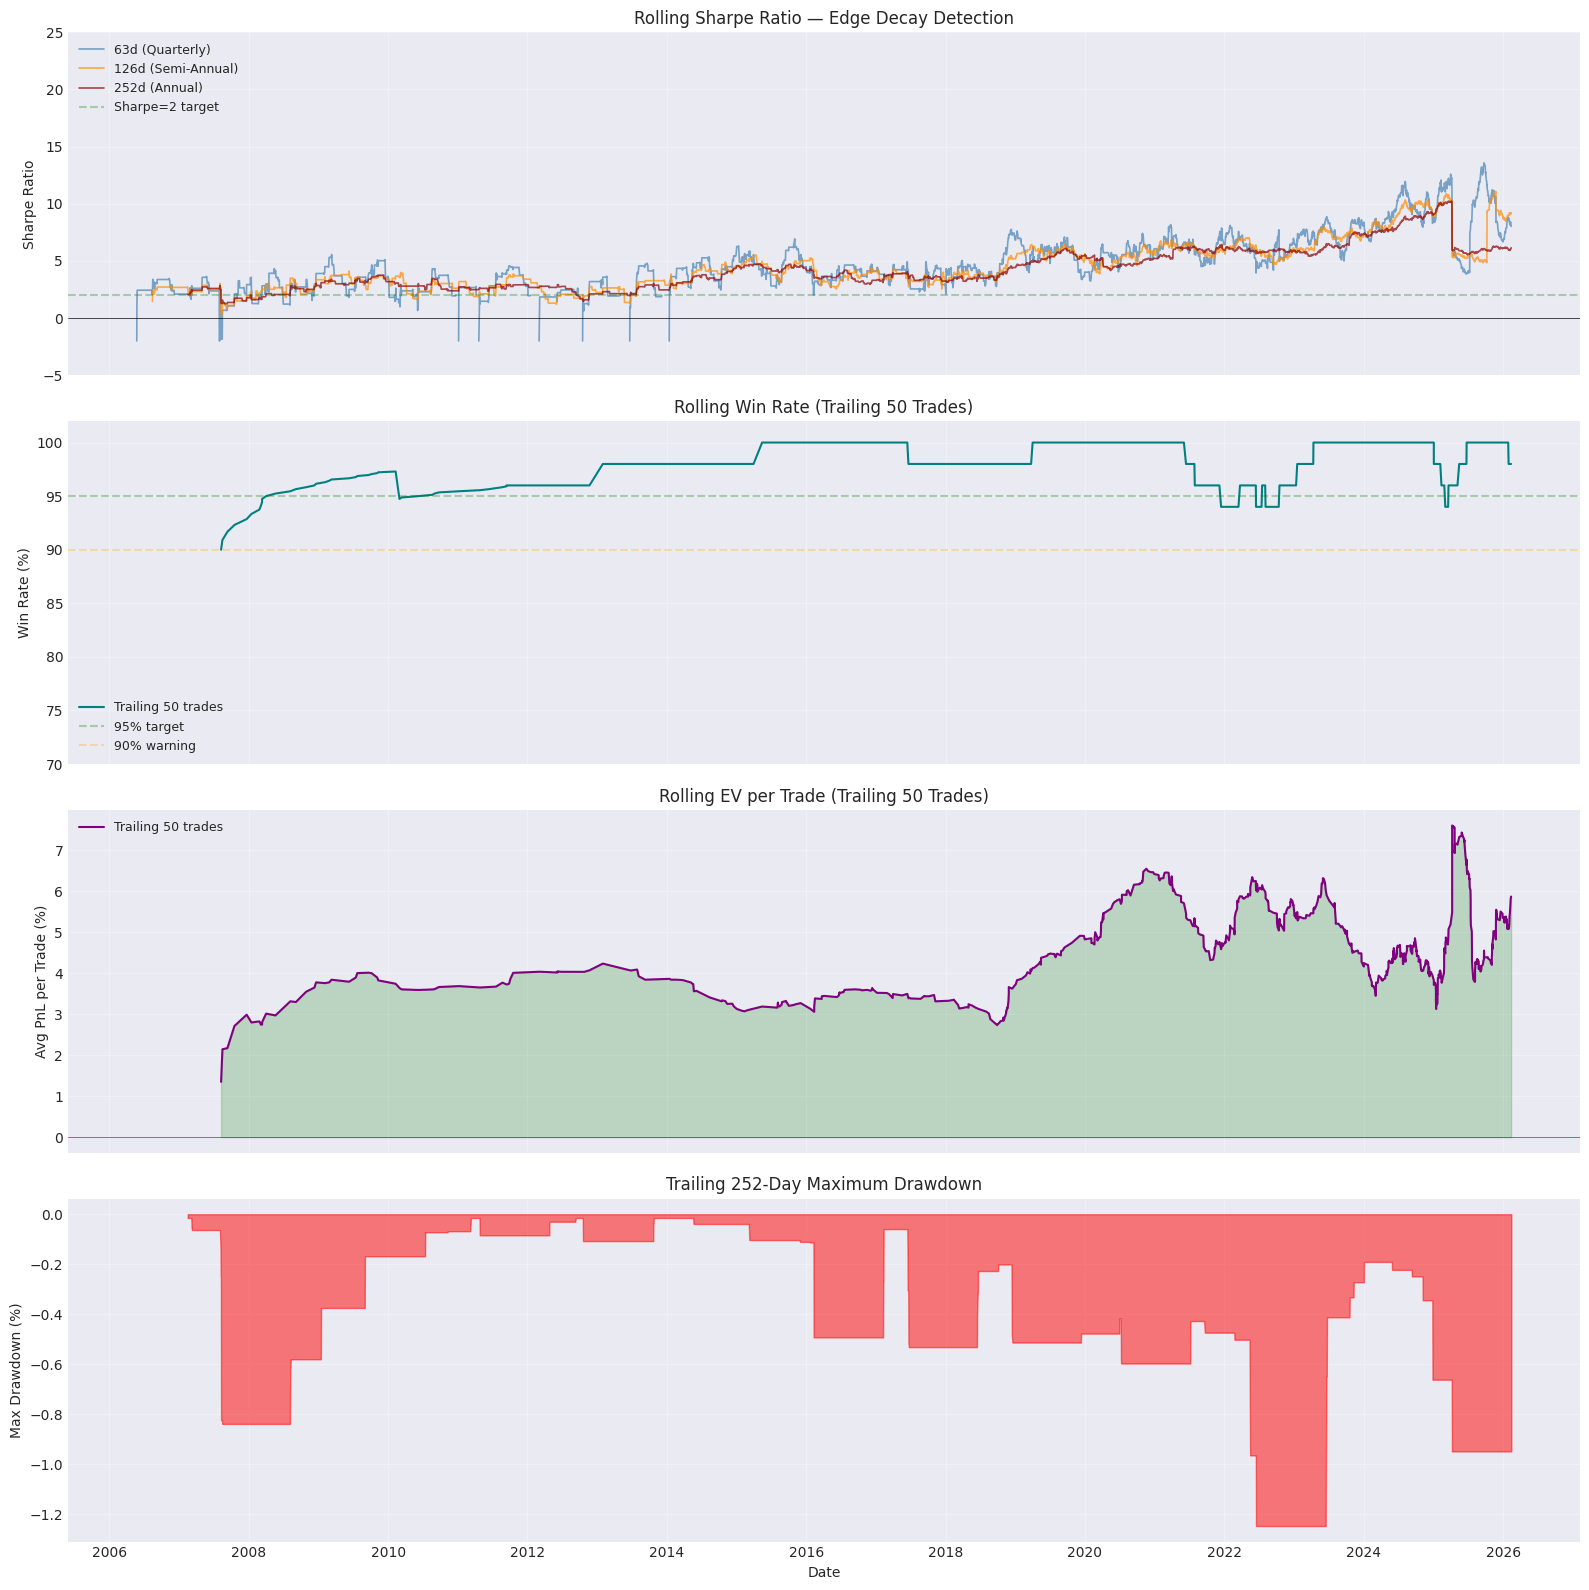

In [ ]:
# 3B.2 — Rolling Analytics (Edge Decay Detection)
analytics.rolling_analytics()

3B.3 — TRADE-LEVEL ANALYTICS

--- Win/Loss Streaks ---
  Max winning streak: 239 trades
  Avg winning streak: 56.4 trades
  Max losing streak:  1 trades
  Avg losing streak:  1.0 trades

--- Holding Period Stats ---
  Mean:   3.6 days
  Median: 3 days
  Mode:   1 days
  Max:    16 days

Saved: /workspaces/Quant/DataAnalysisExpert/3B3_trade_analytics.png


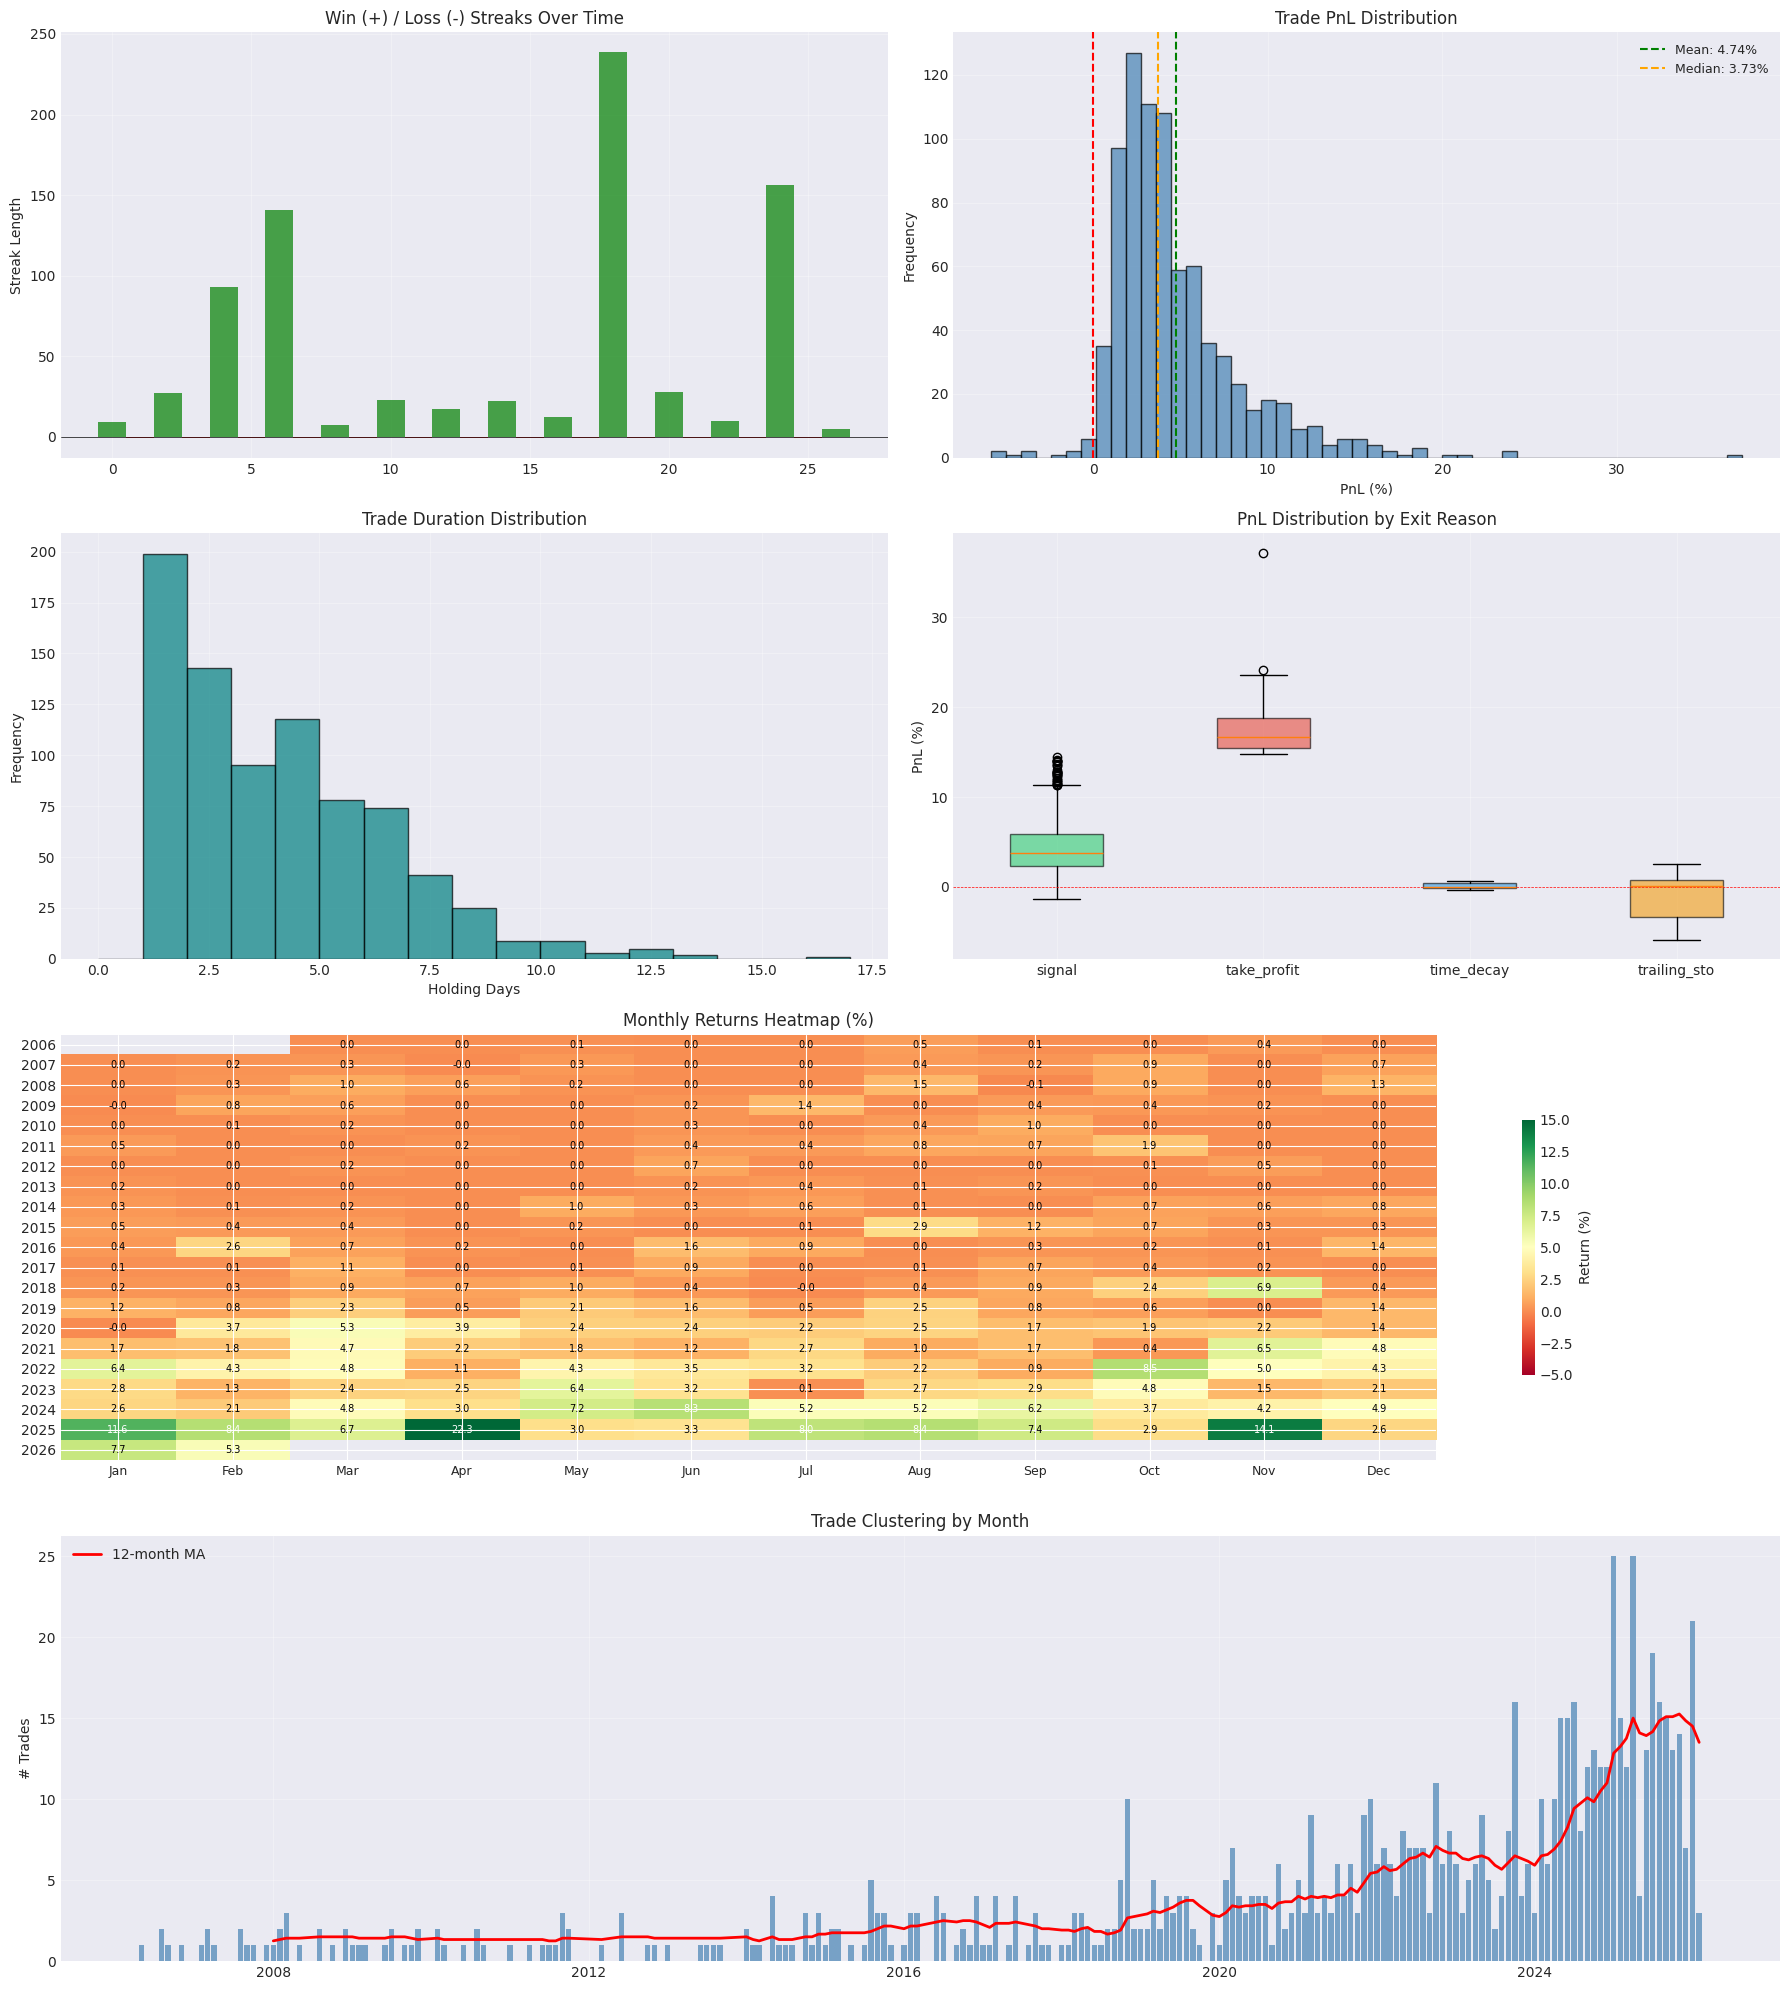

In [ ]:
# 3B.3 — Trade-Level Analytics
analytics.trade_analytics()

In [ ]:
# 3B.4 — Turnover & Cost Analysis
turnover_report = analytics.turnover_analysis()

3B.4 — TURNOVER & COST ANALYSIS

--- Gross vs Net Returns ---
  Gross P&L (before costs):  $4,453,617
  Total commission+slippage: $255,408
  Net P&L (after costs):     $4,198,209
  Cost drag:                 5.73% of gross P&L
  Gross return:              4453.6%
  Net return:                4198.2%

--- Turnover ---
  Total traded value (round-trip): $168,230,040
  Avg portfolio value:             $391,777
  Annual turnover:                 21.50x
  Avg trades per year:             40

--- Cost Efficiency ---
  Commission/Gross ratio:  5.73%
  Avg commission per trade: $318
  Commission rate:         0.15% per side

--- Break-Even Analysis ---
  Avg gross P&L per trade:  5.04%
  Break-even one-way cost:  2.52%
  Current one-way cost:     0.15%
  Safety margin:            2.37%  (16.8x current)

--- Slippage Sensitivity ---
    Slippage   Annual Return    Total Return         Net P&L
  ---------- --------------- --------------- ---------------
       0.05%           20.7%         4201

3B.5 — ENHANCED REGIME ANALYSIS

Regime                                    Period  Trades     WR  AvgPnL   Return  Sharpe   MaxDD    VaR95 Exposure
------------------------------------------------------------------------------------------------------------------------
  Pre-GFC Bull            2006-02-14→2007-09-30      12  91.7%  +2.17%   +2.63%   1.43   0.84% +0.0000%    1.00%
  GFC                     2007-10-01→2009-03-31      17 100.0%  +5.02%   +8.87%   2.96   0.58% -0.0150%    1.43%
  Recovery 2009-11        2009-04-01→2011-12-31      24  95.8%  +3.98%   +9.99%   2.68   0.17% +0.0000%    1.24%
  Low Vol 2012-14         2012-01-01→2014-12-31      29 100.0%  +2.67%   +7.75%   3.10   0.11% +0.0000%    1.35%
  Oil/China Crash         2015-06-01→2016-02-28      17 100.0%  +4.94%   +8.71%   3.83   0.49% -0.0150%    3.08%
  Low Vol Bull 2016-17    2016-03-01→2017-12-31      35  97.1%  +2.62%   +9.59%   3.58   0.53% -0.0150%    2.61%
  Volmageddon 2018        2018-01-01→2018-12-31      


Saved: /workspaces/Quant/DataAnalysisExpert/3B5_regime_analysis.png


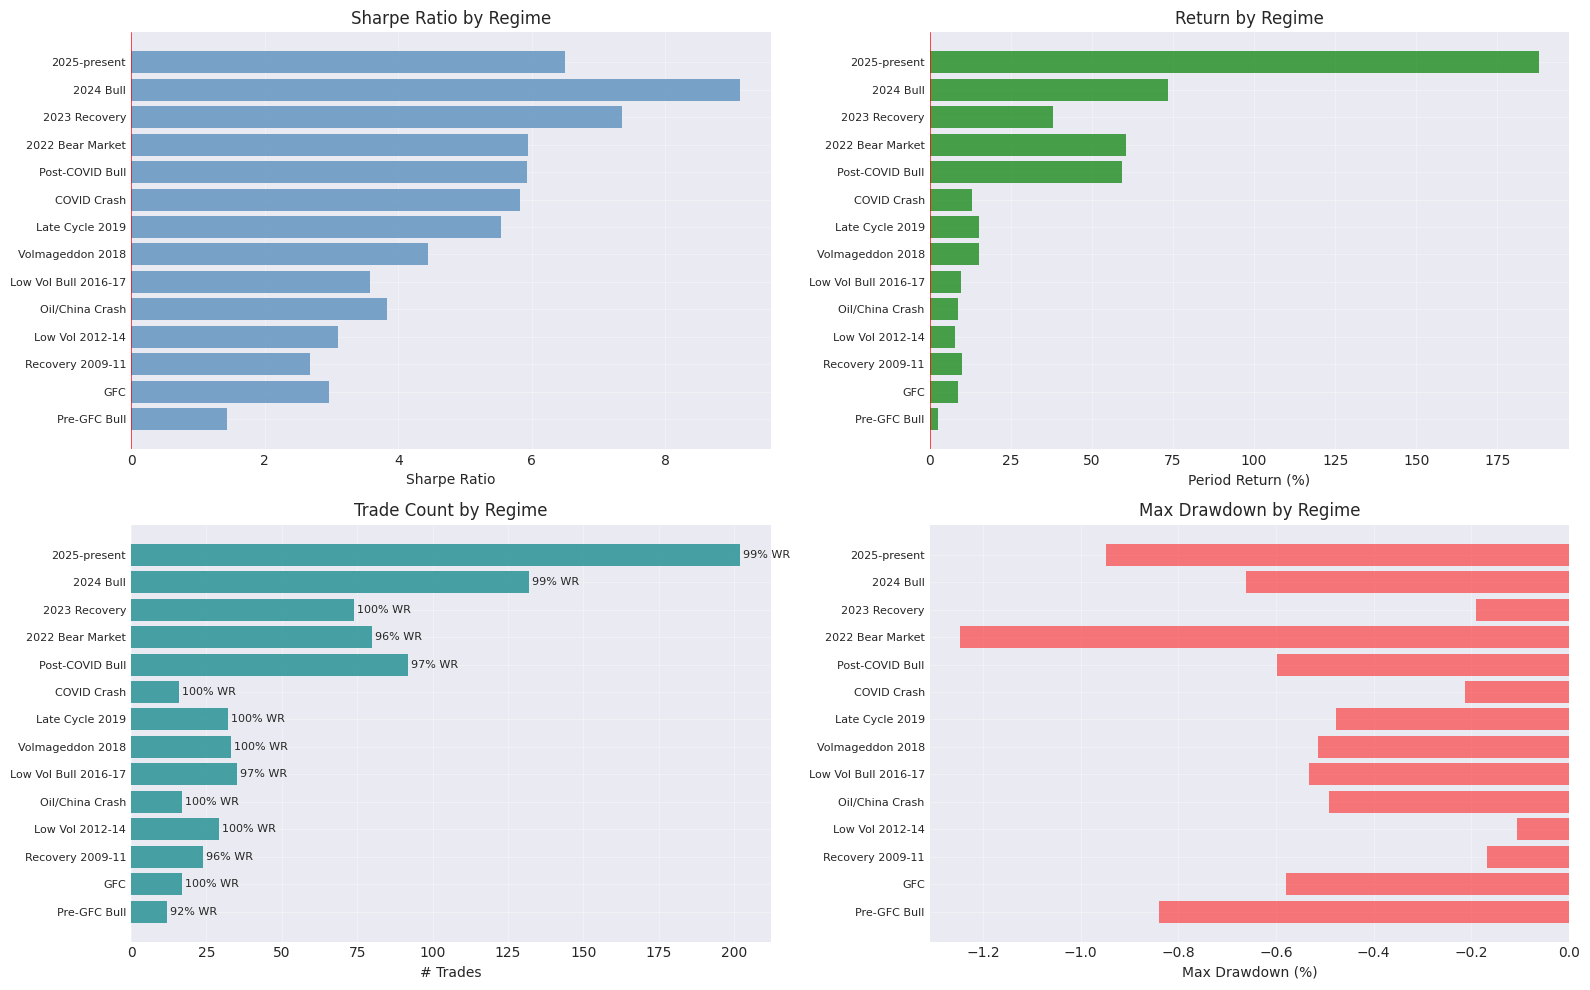


--- Key Regime Insights ---
  Best Sharpe:  2024 Bull (9.12)
  Worst Sharpe: Pre-GFC Bull (1.43)
  All regimes profitable: Yes
  Avg crisis Sharpe: 4.00 (strategy thrives in vol)


In [ ]:
# 3B.5 — Enhanced Regime Analysis
regime_results = analytics.regime_analysis()